In [1]:
import torch
import os
import timm
import cv2
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

torch.cuda.empty_cache()

def create_dataset_df(base_path):
    """Create a DataFrame containing image paths and labels"""
    data = []
    
    # First Set (100x)
    first_set = os.path.join(base_path, 'First Set')
    normal_100x = os.path.join(first_set, '100x Normal Oral Cavity Histopathological Images')
    oscc_100x = os.path.join(first_set, '100x OSCC Histopathological Images')
    
    # Add 100x normal images
    for img_name in os.listdir(normal_100x):
        if img_name.endswith(('.jpg')):
            data.append({
                'path': os.path.join(normal_100x, img_name),
                'label': 0,  # normal
                'magnification': '100x'
            })
    
    # Add 100x OSCC images
    for img_name in os.listdir(oscc_100x):
        if img_name.endswith(('.jpg')):
            data.append({
                'path': os.path.join(oscc_100x, img_name),
                'label': 1,  # OSCC
                'magnification': '100x'
            })
    
    # Second Set (400x)
    second_set = os.path.join(base_path, 'Second Set')
    normal_400x = os.path.join(second_set, '400x Normal Oral Cavity Histopathological Images')
    oscc_400x = os.path.join(second_set, '400x OSCC Histopathological Images')
    
    # Add 400x normal images
    for img_name in os.listdir(normal_400x):
        if img_name.endswith(('.jpg')):
            data.append({
                'path': os.path.join(normal_400x, img_name),
                'label': 0,  # normal
                'magnification': '400x'
            })
    
    # Add 400x OSCC images
    for img_name in os.listdir(oscc_400x):
        if img_name.endswith(('.jpg')):
            data.append({
                'path': os.path.join(oscc_400x, img_name),
                'label': 1,  # OSCC
                'magnification': '400x'
            })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    print(f"Magnification distribution:\n{df['magnification'].value_counts()}")
    return df

class OralCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, row['label']

class ConvNextModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.convnext = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes)
        
        # Modify head for binary classification
        self.convnext.head.fc = nn.Sequential(
            nn.LayerNorm(1024),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.convnext(x)

def get_transforms(is_train=True):
    """Get transforms for training/validation"""
    size = 224  # ConvNext optimal size
    
    if is_train:
        return A.Compose([
            A.RandomResizedCrop(size, size, scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.1, rotate_limit=45),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0)),
                A.GaussianBlur(blur_limit=(3, 7)),
            ], p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(size, size),
            A.Normalize(),
            ToTensorV2()
        ])

def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            val_preds.extend(probs)
            val_labels.extend(labels.cpu().numpy())
    
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    
    auc_roc = roc_auc_score(val_labels, val_preds)
    pred_labels = (val_preds > 0.5).astype(int)
    cm = confusion_matrix(val_labels, pred_labels)
    
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    return {
        'loss': val_loss / len(val_loader),
        'auc_roc': auc_roc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 30
    BASE_PATH = '/kaggle/input/histopathological-imaging-oral-cancer-analysis'
    
    # Create dataset DataFrame
    df = create_dataset_df(BASE_PATH)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    
    train_dataset = OralCancerDataset(train_df, transform=get_transforms(is_train=True))
    val_dataset = OralCancerDataset(val_df, transform=get_transforms(is_train=False))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                          num_workers=2, pin_memory=True)
    
    device = torch.device('cuda')
    model = ConvNextModel().to(device)
    
    class_counts = df['label'].value_counts()
    total_samples = len(df)
    class_weights = torch.FloatTensor([total_samples/(2*class_counts[i]) for i in range(2)]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    best_auc = 0
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
        
        # Validate
        metrics = validate(model, val_loader, criterion, device)
        
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {metrics["loss"]:.4f}')
        print(f'Val AUC-ROC: {metrics["auc_roc"]:.4f}')
        print(f'Sensitivity: {metrics["sensitivity"]:.4f}')
        print(f'Specificity: {metrics["specificity"]:.4f}')
        
        # Update scheduler
        scheduler.step()
        
        if metrics['auc_roc'] > best_auc:
            best_auc = metrics['auc_roc']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_auc': best_auc,
            }, 'best_model.keras')

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Total images: 1224
Class distribution:
label
1    934
0    290
Name: count, dtype: int64
Magnification distribution:
magnification
400x    696
100x    528
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s, loss=0.0736, acc=61.39%]



Epoch 1/30:
Train Loss: 0.6833, Train Acc: 0.6139
Val Loss: 0.4435
Val AUC-ROC: 0.8681
Sensitivity: 0.7380
Specificity: 0.8793


Epoch 2: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.3384, acc=71.71%]



Epoch 2/30:
Train Loss: 0.5269, Train Acc: 0.7171
Val Loss: 0.4083
Val AUC-ROC: 0.9096
Sensitivity: 0.8877
Specificity: 0.7241


Epoch 3: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.1651, acc=83.15%]



Epoch 3/30:
Train Loss: 0.3948, Train Acc: 0.8315
Val Loss: 0.4632
Val AUC-ROC: 0.9198
Sensitivity: 0.9572
Specificity: 0.6379


Epoch 4: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0299, acc=84.17%]



Epoch 4/30:
Train Loss: 0.3768, Train Acc: 0.8417
Val Loss: 0.4389
Val AUC-ROC: 0.9346
Sensitivity: 0.9572
Specificity: 0.7241


Epoch 5: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0017, acc=86.82%]



Epoch 5/30:
Train Loss: 0.3325, Train Acc: 0.8682
Val Loss: 0.4011
Val AUC-ROC: 0.9245
Sensitivity: 0.9144
Specificity: 0.7241


Epoch 6: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s, loss=0.9132, acc=85.39%]



Epoch 6/30:
Train Loss: 0.3151, Train Acc: 0.8539
Val Loss: 0.3393
Val AUC-ROC: 0.9340
Sensitivity: 0.8128
Specificity: 0.8966


Epoch 7: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0122, acc=89.68%]



Epoch 7/30:
Train Loss: 0.2610, Train Acc: 0.8968
Val Loss: 0.4226
Val AUC-ROC: 0.9371
Sensitivity: 0.9037
Specificity: 0.7759


Epoch 8: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0056, acc=92.54%]



Epoch 8/30:
Train Loss: 0.2052, Train Acc: 0.9254
Val Loss: 0.3564
Val AUC-ROC: 0.9480
Sensitivity: 0.9091
Specificity: 0.7586


Epoch 9: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0470, acc=93.56%]



Epoch 9/30:
Train Loss: 0.1762, Train Acc: 0.9356
Val Loss: 0.3221
Val AUC-ROC: 0.9407
Sensitivity: 0.8663
Specificity: 0.8276


Epoch 10: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0284, acc=93.56%]



Epoch 10/30:
Train Loss: 0.1666, Train Acc: 0.9356
Val Loss: 0.3689
Val AUC-ROC: 0.9277
Sensitivity: 0.8824
Specificity: 0.7759


Epoch 11: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0636, acc=94.38%]



Epoch 11/30:
Train Loss: 0.1325, Train Acc: 0.9438
Val Loss: 0.3667
Val AUC-ROC: 0.9551
Sensitivity: 0.9465
Specificity: 0.7759


Epoch 12: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0589, acc=95.71%]



Epoch 12/30:
Train Loss: 0.1103, Train Acc: 0.9571
Val Loss: 0.4115
Val AUC-ROC: 0.9498
Sensitivity: 0.9412
Specificity: 0.8276


Epoch 13: 100%|██████████| 62/62 [00:51<00:00,  1.22it/s, loss=0.0087, acc=95.71%]



Epoch 13/30:
Train Loss: 0.1057, Train Acc: 0.9571
Val Loss: 0.3859
Val AUC-ROC: 0.9415
Sensitivity: 0.9144
Specificity: 0.7931


Epoch 14: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s, loss=0.0006, acc=96.42%]



Epoch 14/30:
Train Loss: 0.0903, Train Acc: 0.9642
Val Loss: 0.5627
Val AUC-ROC: 0.9421
Sensitivity: 0.9358
Specificity: 0.6897


Epoch 15: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0014, acc=97.04%]



Epoch 15/30:
Train Loss: 0.0781, Train Acc: 0.9704
Val Loss: 0.4651
Val AUC-ROC: 0.9560
Sensitivity: 0.9358
Specificity: 0.7759


Epoch 16: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0017, acc=96.22%]



Epoch 16/30:
Train Loss: 0.1036, Train Acc: 0.9622
Val Loss: 0.4900
Val AUC-ROC: 0.9446
Sensitivity: 0.9251
Specificity: 0.8276


Epoch 17: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s, loss=0.0013, acc=97.85%]



Epoch 17/30:
Train Loss: 0.0658, Train Acc: 0.9785
Val Loss: 0.5215
Val AUC-ROC: 0.9422
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 18: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0037, acc=98.77%] 



Epoch 18/30:
Train Loss: 0.0486, Train Acc: 0.9877
Val Loss: 0.5516
Val AUC-ROC: 0.9451
Sensitivity: 0.9572
Specificity: 0.7586


Epoch 19: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0187, acc=98.16%]



Epoch 19/30:
Train Loss: 0.0547, Train Acc: 0.9816
Val Loss: 0.5771
Val AUC-ROC: 0.9461
Sensitivity: 0.9305
Specificity: 0.8276


Epoch 20: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0004, acc=97.75%]



Epoch 20/30:
Train Loss: 0.0551, Train Acc: 0.9775
Val Loss: 0.5221
Val AUC-ROC: 0.9473
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 21: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0001, acc=98.57%]



Epoch 21/30:
Train Loss: 0.0321, Train Acc: 0.9857
Val Loss: 0.6148
Val AUC-ROC: 0.9538
Sensitivity: 0.9519
Specificity: 0.7069


Epoch 22: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0118, acc=98.88%]



Epoch 22/30:
Train Loss: 0.0347, Train Acc: 0.9888
Val Loss: 0.5533
Val AUC-ROC: 0.9436
Sensitivity: 0.9144
Specificity: 0.8103


Epoch 23: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0784, acc=98.67%]



Epoch 23/30:
Train Loss: 0.0290, Train Acc: 0.9867
Val Loss: 0.5986
Val AUC-ROC: 0.9516
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 24: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s, loss=0.0001, acc=99.18%]



Epoch 24/30:
Train Loss: 0.0170, Train Acc: 0.9918
Val Loss: 0.6213
Val AUC-ROC: 0.9533
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 25: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.2694, acc=98.88%]



Epoch 25/30:
Train Loss: 0.0241, Train Acc: 0.9888
Val Loss: 0.6377
Val AUC-ROC: 0.9514
Sensitivity: 0.9358
Specificity: 0.7759


Epoch 26: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0001, acc=99.08%]



Epoch 26/30:
Train Loss: 0.0333, Train Acc: 0.9908
Val Loss: 0.6357
Val AUC-ROC: 0.9516
Sensitivity: 0.9412
Specificity: 0.7931


Epoch 27: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0001, acc=98.57%]



Epoch 27/30:
Train Loss: 0.0242, Train Acc: 0.9857
Val Loss: 0.6470
Val AUC-ROC: 0.9523
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 28: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0033, acc=99.08%] 



Epoch 28/30:
Train Loss: 0.0189, Train Acc: 0.9908
Val Loss: 0.6493
Val AUC-ROC: 0.9525
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 29: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.5009, acc=98.88%]



Epoch 29/30:
Train Loss: 0.0305, Train Acc: 0.9888
Val Loss: 0.6477
Val AUC-ROC: 0.9524
Sensitivity: 0.9412
Specificity: 0.7759


Epoch 30: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s, loss=0.0022, acc=98.88%]



Epoch 30/30:
Train Loss: 0.0272, Train Acc: 0.9888
Val Loss: 0.6507
Val AUC-ROC: 0.9524
Sensitivity: 0.9412
Specificity: 0.7586


In [9]:
class ModelAnalyzer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = ConvNextModel().to(device)
        checkpoint = torch.load(model_path, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
    def predict_image(self, image_path):
        """Predict single image"""
        transform = get_transforms(is_train=False)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = transform(image=image)['image']
        
        image = image.unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image)
            probabilities = torch.softmax(outputs, dim=1)
            
        return probabilities.cpu().numpy()[0]

    def get_all_predictions(self, val_loader):
        """Get predictions for entire validation set"""
        all_preds = []
        all_labels = []
        all_probs = []
        
        self.model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())
                
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_metrics(history):
    """Plot training history metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'OSCC']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def plot_roc_curve(y_true, y_prob):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_prediction_examples(analyzer, image_paths, actual_labels, num_examples=5):
    """Plot example predictions"""
    plt.figure(figsize=(15, 3*num_examples))
    
    for i, (img_path, true_label) in enumerate(zip(image_paths[:num_examples], actual_labels[:num_examples])):
        # Get prediction
        probs = analyzer.predict_image(img_path)
        pred_label = np.argmax(probs)
        
        # Read and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f'True: {"OSCC" if true_label == 1 else "Normal"} | ' 
                 f'Predicted: {"OSCC" if pred_label == 1 else "Normal"} '
                 f'(Confidence: {probs[pred_label]:.2%})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
def analyze_model(model_path, val_loader, val_df):
    analyzer = ModelAnalyzer(model_path)
    
    # Get predictions
    y_true, y_pred, y_prob = analyzer.get_all_predictions(val_loader)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob)
    
    # Plot example predictions
    sample_indices = np.random.choice(len(val_df), 5, replace=False)
    sample_images = val_df.iloc[sample_indices]['path'].tolist()
    sample_labels = val_df.iloc[sample_indices]['label'].tolist()
    plot_prediction_examples(analyzer, sample_images, sample_labels)

# For inference on new images:
def predict_new_images(model_path, image_folder):
    analyzer = ModelAnalyzer(model_path)
    results = []
    
    for img_name in os.listdir(image_folder):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(image_folder, img_name)
            probs = analyzer.predict_image(img_path)
            pred_label = np.argmax(probs)
            confidence = probs[pred_label]
            
            results.append({
                'image': img_name,
                'prediction': 'OSCC' if pred_label == 1 else 'Normal',
                'confidence': confidence
            })
    
    return pd.DataFrame(results)

Total images: 1224
Class distribution:
label
1    934
0    290
Name: count, dtype: int64
Magnification distribution:
magnification
400x    696
100x    528
Name: count, dtype: int64


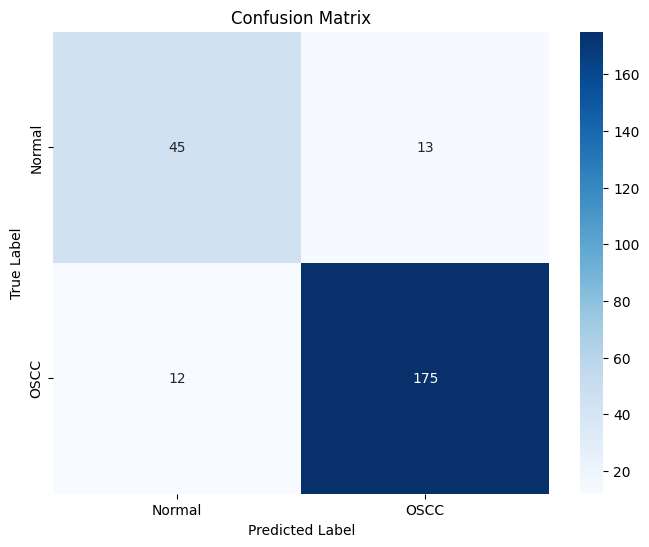


Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.78      0.78        58
        OSCC       0.93      0.94      0.93       187

    accuracy                           0.90       245
   macro avg       0.86      0.86      0.86       245
weighted avg       0.90      0.90      0.90       245



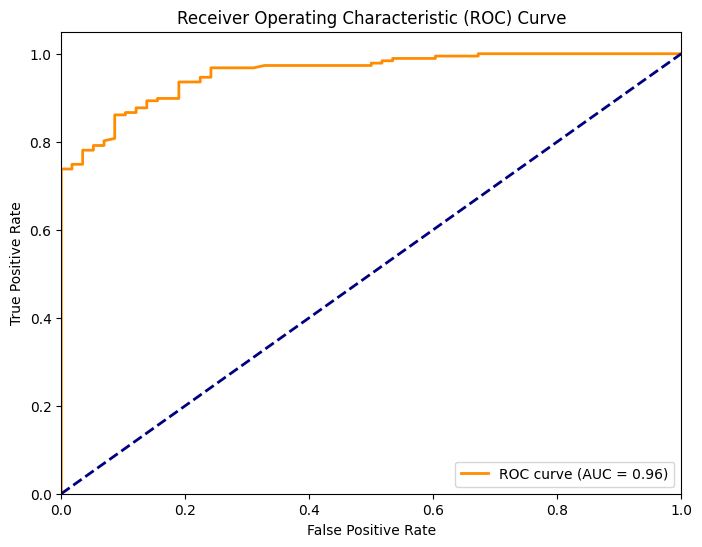

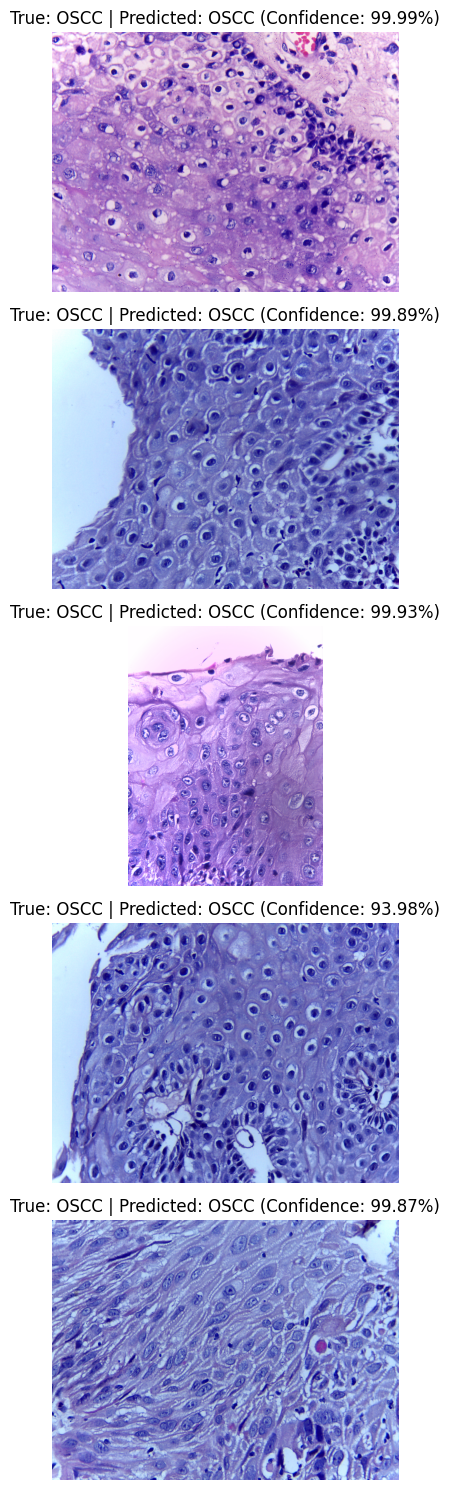

In [12]:
BASE_PATH = '/kaggle/input/histopathological-imaging-oral-cancer-analysis'
MODEL_PATH = '/kaggle/working/best_model.keras'

df = create_dataset_df(BASE_PATH)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

val_dataset = OralCancerDataset(val_df, transform=get_transforms(is_train=False))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

analyze_model(MODEL_PATH, val_loader, val_df)